In [32]:
import os
import sys
import numpy as np
import neuroglancer
from skimage import io
import matplotlib
from pprint import pprint
from matplotlib import pyplot as plt
from tqdm import tqdm
import cv2
from pathlib import Path
from tifffile import imwrite
import SimpleITK as sitk
from scipy.ndimage import zoom
PIPELINE_ROOT = Path('.').resolve().parent.parent
sys.path.append(PIPELINE_ROOT.as_posix())

from library.utilities.utilities_mask import normalize16

In [25]:
filename = 'allen_10um_sagittal.tif'
DATA = '/net/birdstore/Active_Atlas_Data/data_root/brains_info/registration'
filepath = os.path.join(DATA, filename)
fixedvolume = io.imread(filepath)
print(f'Volume shape={volume.shape} dtype={volume.dtype}')

Volume shape=(1140, 800, 1320) dtype=uint16


In [26]:
filename = 'moving_volume.tif'
DATA = '/net/birdstore/Active_Atlas_Data/data_root/pipeline_data/DK52/preps/CH1'
filepath = os.path.join(DATA, filename)
volume = io.imread(filepath)
print(f'Volume shape={volume.shape} dtype={volume.dtype}')

Volume shape=(486, 555, 1024) dtype=uint16


In [30]:
scaled = zoom(volume, zoom=(1, 800/555, 1320/1024))
print(scaled.shape)

(486, 800, 1320)


In [31]:
outpath = os.path.join(DATA, 'scaled_volume.64.tif')
imwrite(outpath, scaled)

In [35]:
fixed_file = '/net/birdstore/Active_Atlas_Data/data_root/brains_info/registration/allen_25um_sagittal.tif'
moving_file = '/net/birdstore/Active_Atlas_Data/data_root/pipeline_data/DK52/preps/CH1/moving_volume.tif'
pixelType = sitk.sitkFloat32
fixed_image = sitk.ReadImage(fixed_file, pixelType)
moving_image = sitk.ReadImage(moving_file, pixelType)

In [37]:
DATA

'/net/birdstore/Active_Atlas_Data/data_root/pipeline_data/DK52/preps/CH1'

In [36]:
initial_transform = sitk.CenteredTransformInitializer(fixed_image, 
                                                      moving_image, 
                                                      sitk.Euler3DTransform(), 
                                                      sitk.CenteredTransformInitializerFilter.GEOMETRY)

moving_resampled = sitk.Resample(moving_image, fixed_image, initial_transform, sitk.sitkLinear, 0.0, moving_image.GetPixelID())

In [24]:
vm2 = np.swapaxes(volume, 0,2)
print(vm2.shape)
outpath = os.path.join(DATA, 'allen_50um_sagittal.tif')
imwrite(outpath, vm2)

(228, 160, 264)


In [ ]:
sagittal = volume.swapaxes(-2,-1)[...,::-1]
sagittal = np.flip(sagittal, axis=2)
arr = sagittal
#arr = np.swapaxes(volume, 1,2)
midpoint = arr.shape[2] // 2
plt.title('Z {}'.format(i))
img = arr[:,:,midpoint]
#img = np.rot90(img, 1, axes=(1,0))
#img = np.flip(img, axis=1)
plt.imshow(img, cmap="seismic")
plt.show()

 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 3/5 [00:00<00:00,  9.79it/s]

img shape=(640, 352) img2 shape=(1280, 1056)
img shape=(640, 352) img2 shape=(1280, 1056)
img shape=(640, 352) img2 shape=(1280, 1056)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.82it/s]


img shape=(640, 352) img2 shape=(1280, 1056)
img shape=(640, 352) img2 shape=(1280, 1056)


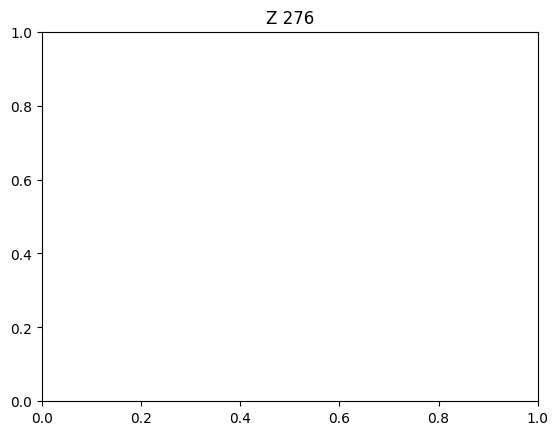

In [17]:
#arr = normalize16(volume)
arr = volume
arr = np.swapaxes(volume, 0,2)
midpoint = arr.shape[2] // 2
limit = 8
start = midpoint - 10
end = midpoint + 10
for i in tqdm(range(start, end, 4)):
    plt.title('Z {}'.format(i))
    img = arr[:,:,i]
    #img = np.rot90(img, 1, axes=(1,0))
    #img = np.flip(img, axis=1)
    #plt.imshow(img, cmap="seismic")
    #plt.show()

In [ ]:
image_stack = np.zeros(volume.shape)
file_list = []

for i in tqdm(range(0, volume.shape[2], 1)):
    img = volume[:,:,i]
    img = np.rot90(img, 1, axes=(1,0))
    img = np.flip(img, axis=1)
    filepath = os.path.join(OUTPUT, str(i).zfill(3) + '.tif')
    cv2.imwrite(filepath, img)

In [4]:
# The default atlas created by brainreg is isotropic 25um
vm2 = volume
#print(f'Orig volume shape={sagittal.shape}')
#vm2 = np.swapaxes(volume, 0,2)
#sagittal = np.rot90(sagittal, axes=(1, 0))
#sagittal = np.flip(sagittal, axis=1)
print(f'new volume shape={vm2.shape}')

dimensions = neuroglancer.CoordinateSpace(
    names=['x', 'y', 'z'],
    units='um',
    scales=[20,20,20])
viewer = neuroglancer.Viewer()
with viewer.txn() as s:
    s.dimensions = dimensions
    s.layout = '4panel'
    s.layers['Princeton'] = neuroglancer.SegmentationLayer(
        source=neuroglancer.LocalVolume(
            data=vm2,
            dimensions=dimensions,
            voxel_offset=(0, 0, 0),
        ))

print(viewer)

new volume shape=(540, 352, 640)
http://127.0.0.1:41169/v/16f21bc2580a667684704f132cdc3f8b80e14fb8/
